<a href="https://colab.research.google.com/github/HaniyeDousti/Machine-Learning-Project/blob/main/Softmaxregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
from time import time
#from .._base import _BaseClassifier
#from .._base import _BaseMultiClass


class SoftmaxRegression(object):

    """Softmax regression classifier.

    Parameters
    ------------
    eta : float (default: 0.01)
        Learning rate (between 0.0 and 1.0)
    epochs : int (default: 50)
        Passes over the training dataset.
        Prior to each epoch, the dataset is shuffled
        if `minibatches > 1` to prevent cycles in stochastic gradient descent.
    l2 : float
        Regularization parameter for L2 regularization.
        No regularization if l2=0.0.
    minibatches : int (default: 1)
        The number of minibatches for gradient-based optimization.
        If 1: Gradient Descent learning
        If len(y): Stochastic Gradient Descent (SGD) online learning
        If 1 < minibatches < len(y): SGD Minibatch learning
    n_classes : int (default: None)
        A positive integer to declare the number of class labels
        if not all class labels are present in a partial training set.
        Gets the number of class labels automatically if None.
    random_seed : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    w_ : 2d-array, shape={n_features, 1}
      Model weights after fitting.
    b_ : 1d-array, shape={1,}
      Bias unit after fitting.
    cost_ : list
        List of floats, the average cross_entropy for each epoch.

    """
    def __init__(self, eta=0.01, epochs=50,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):

        self.eta = eta
        self.epochs = epochs
        self.l2 = l2
        self.minibatches = minibatches
        self.n_classes = n_classes
        self.random_seed = random_seed

    def _fit(self, X, y, init_params=True):
        if init_params:
            if self.n_classes is None:
                self.n_classes = np.max(y) + 1
            self._n_features = X.shape[1]

            self.b_, self.w_ = self._init_params(
                weights_shape=(self._n_features, self.n_classes),
                bias_shape=(self.n_classes,),
                random_seed=self.random_seed)
            self.cost_ = []

        y_enc = self._one_hot(y=y, n_labels=self.n_classes, dtype=np.float)

        for i in range(self.epochs):
            for idx in self._yield_minibatches_idx(
                    n_batches=self.minibatches,
                    data_ary=y,
                    shuffle=True):
                # givens:
                # w_ -> n_feat x n_classes
                # b_  -> n_classes

                # net_input, softmax and diff -> n_samples x n_classes:
                net = self._net_input(X[idx], self.w_, self.b_)
                softm = self._softmax(net)
                diff = softm - y_enc[idx]
                mse = np.mean(diff, axis=0)

                # gradient -> n_features x n_classes
                grad = np.dot(X[idx].T, diff)
                
                # update in opp. direction of the cost gradient
                self.w_ -= (self.eta * grad +
                            self.eta * self.l2 * self.w_)
                self.b_ -= (self.eta * np.sum(diff, axis=0))

            # compute cost of the whole epoch
            net = self._net_input(X, self.w_, self.b_)
            softm = self._softmax(net)
            cross_ent = self._cross_entropy(output=softm, y_target=y_enc)
            cost = self._cost(cross_ent)
            self.cost_.append(cost)
        return self

    def fit(self, X, y, init_params=True):
        """Learn model from training data.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.
        init_params : bool (default: True)
            Re-initializes model parametersprior to fitting.
            Set False to continue training with weights from
            a previous model fitting.

        Returns
        -------
        self : object

        """
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
        self._fit(X=X, y=y, init_params=init_params)
        self._is_fitted = True
        return self
    
    def _predict(self, X):
        probas = self.predict_proba(X)
        return self._to_classlabels(probas)
 
    def predict(self, X):
        """Predict targets from X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        target_values : array-like, shape = [n_samples]
          Predicted target values.

        """
        if not self._is_fitted:
            raise AttributeError('Model is not fitted, yet.')
        return self._predict(X)

    def predict_proba(self, X):
        """Predict class probabilities of X from the net input.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        Class probabilties : array-like, shape= [n_samples, n_classes]

        """
        net = self._net_input(X, self.w_, self.b_)
        softm = self._softmax(net)
        return softm

    def _net_input(self, X, W, b):
        return (X.dot(W) + b)

    def _softmax(self, z):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def _cross_entropy(self, output, y_target):
        return - np.sum(np.log(output) * (y_target), axis=1)

    def _cost(self, cross_entropy):
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        cross_entropy = cross_entropy + L2_term
        return 0.5 * np.mean(cross_entropy)

    def _to_classlabels(self, z):
        return z.argmax(axis=1)
    
    def _init_params(self, weights_shape, bias_shape=(1,), dtype='float64',
                     scale=0.01, random_seed=None):
        """Initialize weight coefficients."""
        if random_seed:
            np.random.seed(random_seed)
        w = np.random.normal(loc=0.0, scale=scale, size=weights_shape)
        b = np.zeros(shape=bias_shape)
        return b.astype(dtype), w.astype(dtype)
    
    def _one_hot(self, y, n_labels, dtype):
        """Returns a matrix where each sample in y is represented
           as a row, and each column represents the class label in
           the one-hot encoding scheme.

        Example:

            y = np.array([0, 1, 2, 3, 4, 2])
            mc = _BaseMultiClass()
            mc._one_hot(y=y, n_labels=5, dtype='float')

            np.array([[1., 0., 0., 0., 0.],
                      [0., 1., 0., 0., 0.],
                      [0., 0., 1., 0., 0.],
                      [0., 0., 0., 1., 0.],
                      [0., 0., 0., 0., 1.],
                      [0., 0., 1., 0., 0.]])

        """
        mat = np.zeros((len(y), n_labels))
        for i, val in enumerate(y):
            mat[i, val] = 1
        return mat.astype(dtype)    
    
    def _yield_minibatches_idx(self, n_batches, data_ary, shuffle=True):
            indices = np.arange(data_ary.shape[0])

            if shuffle:
                indices = np.random.permutation(indices)
            if n_batches > 1:
                remainder = data_ary.shape[0] % n_batches

                if remainder:
                    minis = np.array_split(indices[:-remainder], n_batches)
                    minis[-1] = np.concatenate((minis[-1],
                                                indices[-remainder:]),
                                               axis=0)
                else:
                    minis = np.array_split(indices, n_batches)

            else:
                minis = (indices,)

            for idx_batch in minis:
                yield idx_batch
    
    def _shuffle_arrays(self, arrays):
        """Shuffle arrays in unison."""
        r = np.random.permutation(len(arrays[0]))
        return [ary[r] for ary in arrays]

**1. Gradient Descent** 

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.data import iris_datplot_decision_regionsa
from mlxtend.plotting import 


Loading Data

In [41]:
X, y = iris_data()
X = X[:, [0, 3]]

In [52]:
X

array([[-7.43333333e-01, -9.98666667e-01],
       [-9.43333333e-01, -9.98666667e-01],
       [-1.14333333e+00, -9.98666667e-01],
       [-1.24333333e+00, -9.98666667e-01],
       [-8.43333333e-01, -9.98666667e-01],
       [-4.43333333e-01, -7.98666667e-01],
       [-1.24333333e+00, -8.98666667e-01],
       [-8.43333333e-01, -9.98666667e-01],
       [-1.44333333e+00, -9.98666667e-01],
       [-9.43333333e-01, -1.09866667e+00],
       [-4.43333333e-01, -9.98666667e-01],
       [-1.04333333e+00, -9.98666667e-01],
       [-1.04333333e+00, -1.09866667e+00],
       [-1.54333333e+00, -1.09866667e+00],
       [-4.33333333e-02, -9.98666667e-01],
       [-1.43333333e-01, -7.98666667e-01],
       [-4.43333333e-01, -7.98666667e-01],
       [-7.43333333e-01, -8.98666667e-01],
       [-1.43333333e-01, -8.98666667e-01],
       [-7.43333333e-01, -8.98666667e-01],
       [-4.43333333e-01, -9.98666667e-01],
       [-7.43333333e-01, -7.98666667e-01],
       [-1.24333333e+00, -9.98666667e-01],
       [-7.

In [53]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Standardize

In [44]:
X[:, 0] = (X[:,0] - X[:, 0].mean())
X[:, 1] = (X[:, 1] - X[:, 1].mean())

In [45]:
lr = SoftmaxRegression(eta=0.01, epochs=10, minibatches=1, random_seed=0)

In [46]:
lr.fit(X, y)

<ipython-input-25-52383643315a>:69: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_enc = self._one_hot(y=y, n_labels=self.n_classes, dtype=np.float)


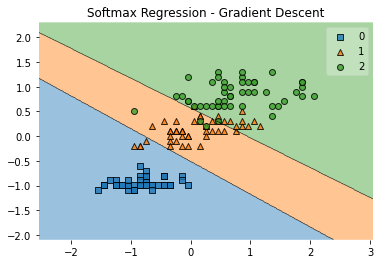

<function matplotlib.pyplot.show(*args, **kw)>

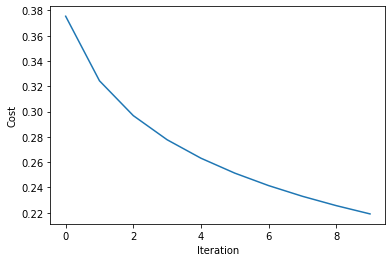

In [47]:
plot_decision_regions(X, y, clf=lr)
plt.title('Softmax Regression - Gradient Descent')
plt.show()

plt.plot(range(len(lr.cost_)), lr.cost_)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show

<ipython-input-25-52383643315a>:69: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_enc = self._one_hot(y=y, n_labels=self.n_classes, dtype=np.float)


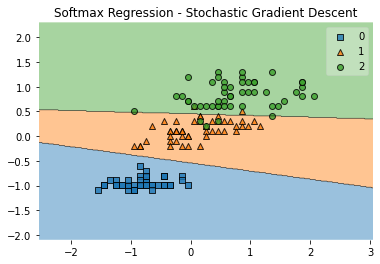

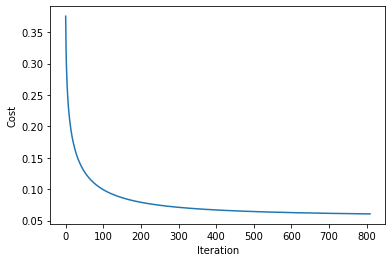

In [48]:
lr.epochs = 800

lr.fit(X, y, init_params=False)

plot_decision_regions(X, y, clf=lr)
plt.title('Softmax Regression - Stochastic Gradient Descent')
plt.show()

plt.plot(range(len(lr.cost_)), lr.cost_)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

**Predicting Class Label**

In [54]:
y_pred = lr.predict(X)
print('Last 3 Class Labels: %s' % y_pred[-3:])

Last 3 Class Labels: [2 2 2]


**Predicting Class Probabilities**

In [55]:
y_pred = lr.predict_proba(X)
print('Last 3 Class Labels: \n %s' % y_pred[-3:])

Last 3 Class Labels: 
 [[8.04165704e-09 1.74309906e-02 9.82569001e-01]
 [2.86446606e-11 7.69405946e-04 9.99230594e-01]
 [1.48322727e-06 1.60370175e-01 8.39628341e-01]]


**2. Stochastic Gradient Descent**

In [ ]:
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

**Loading Data**

In [61]:
X, y = iris_data()
X = X[:, [0, 3]]

**standardize**

In [63]:
X[:, 0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X[:, 1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

In [64]:
lr = SoftmaxRegression(eta=0.05, epochs=200, minibatches=len(y), random_seed=0)
lr.fit(X, y)

<ipython-input-57-52383643315a>:69: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_enc = self._one_hot(y=y, n_labels=self.n_classes, dtype=np.float)


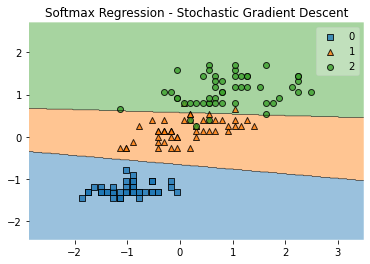

AttributeError: ignored

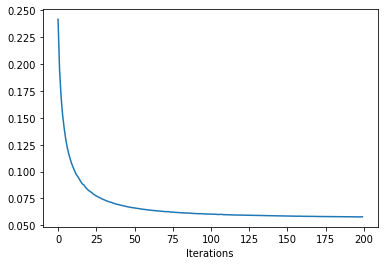

In [66]:
plot_decision_regions(X, y, clf=lr)
plt.title('Softmax Regression - Stochastic Gradient Descent')
plt.show()

plt.plot(range(len(lr.cost_)), lr.cost_)
plt.xlabel('Iterations')
plt.ylabels('Cost')
plt.show()